In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [12]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv("/content/drive/My Drive/Projects/NLP-Notebooks/1.2-sentiment-analysis/imdb_dataset_small.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [16]:
class EDA():
    def get_length_dist(self,data):
        rev_len = [len(i) for i in data]
        pd.Series(rev_len).hist()
        plt.title('Number of types of commets')
        plt.xlabel('length')
        plt.ylabel('number')
        plt.show()
        print(pd.Series(rev_len).describe())
    def get_class_dist(self,df):
        df['sentiment'].replace({1:'positive',0:'negative'}).value_counts().plot(kind='bar',figsize=(7,4))
        plt.title('Number of types')
        plt.xlabel('Comment_type')
        plt.ylabel('number')
        plt.show()

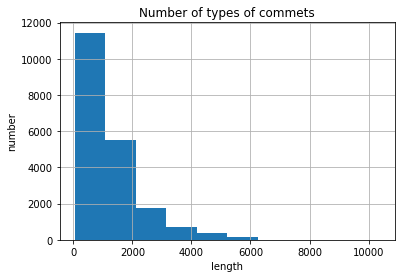

count    20000.000000
mean      1309.473600
std        992.044975
min         52.000000
25%        697.000000
50%        964.000000
75%       1592.000000
max      10363.000000
dtype: float64


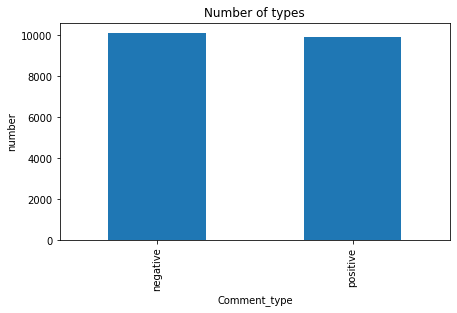

In [8]:
eda = EDA()
eda.get_length_dist(df['review'])
eda.get_class_dist(df)


In [17]:
class Tokenizer():

    def tokenize(self,data):
        self.words = []

        for sent in data:
            for word in sent.lower().split():
                self.words.append(word)
    
        corpus = Counter(self.words)
        corpus = sorted(corpus,key=corpus.get,reverse=True)[:1000]
        self.vocab = {"pad":0}
        self.vocab.update({w:i+1 for i,w in enumerate(corpus)})
        self.vocab.update({"unk":len(self.vocab)+1})

In [19]:
class PreprocessData():

    def split_data(self,df):
        x,y = df['review'].values,df['sentiment'].values
        x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y)
        print(f'shape of train data is {x_train.shape}')
        print(f'shape of test data is {x_test.shape}')
        return x_train,x_test,y_train,y_test
    
    def preprocess_string(self,text):
        # Remove all non-word characters (everything except numbers and letters)
        text = re.sub(r"[^\w\s]", '', text)
        # Replace all runs of whitespaces with no space
        text = re.sub(r"\s+", '', text)
        # replace digits with no space
        text = re.sub(r"\d", '', text)
        return text
    def padding(self,sentences, seq_len):
        features = np.zeros((len(sentences), seq_len),dtype=int)
        for ii, review in enumerate(sentences):
            if len(review) != 0:
                features[ii, -len(review):] = np.array(review)[:seq_len]
        return features

    def encode(self,text_list,vocab):
        output = list()
        for sent in text_list:
            enc_words = list()
            for word in sent.lower().split():
                try:
                    enc_words.append(vocab[word])
                except:
                    enc_words.append(vocab["unk"])
            output.append(enc_words)
        return np.array(output)

    def get_label_encode(self,data):
        label_data = [1 if label =='positive' else 0 for label in data]
        return np.array(label_data)


In [20]:
tknzr = Tokenizer()
tknzr.tokenize(df['review'].values)
vocab = tknzr.vocab

In [21]:
prp_obj = PreprocessData()
x_train,x_test,y_train,y_test = prp_obj.split_data(df)
x_train = prp_obj.encode(x_train,vocab)
x_test = prp_obj.encode(x_test,vocab)
y_train = prp_obj.get_label_encode(y_train)
y_test = prp_obj.get_label_encode(y_test)
x_train_pad = prp_obj.padding(x_train,500)
x_test_pad = prp_obj.padding(x_test,500)

shape of train data is (15000,)
shape of test data is (5000,)


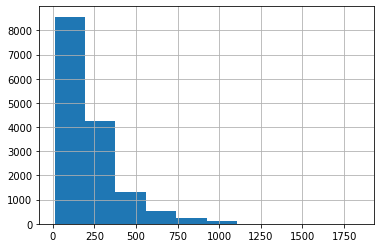

count    15000.000000
mean       230.590133
std        171.424307
min         10.000000
25%        126.000000
50%        172.000000
75%        278.250000
max       1839.000000
dtype: float64

In [44]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1002,  525, 1002],
        [   0,    0,    0,  ...,  125, 1002, 1002],
        [   0,    0,    0,  ..., 1002,   33, 1002],
        ...,
        [   0,    0,    0,  ..., 1002,    5, 1002],
        [   0,    0,    0,  ...,    3,   87, 1002],
        [   0,    0,    0,  ..., 1002,   12, 1002]])
Sample input: 
 tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0])


In [31]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [45]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1003, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [53]:
class DefineModel():
    def __init__(self,model):
        self.model = model
        self.lr=0.001

    def get_loss(self):
        criterion = nn.BCELoss()
        return criterion

    def get_optimizer(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        return optimizer

    def get_accuracy(self,pred,label):
        pred = torch.round(pred.squeeze())
        return torch.sum(pred == label.squeeze()).item()

    def train(self,epochs,batch_size):
        clip = 5
        valid_loss_min = np.Inf
        # train for some number of epochs
        self.epoch_tr_loss = list()
        self.epoch_vl_loss = list()
        self.epoch_tr_acc = list()
        self.epoch_vl_acc = list()

        for epoch in range(epochs):
            train_losses = []
            train_acc = 0.0
            self.model.train()
            # initialize hidden state 
            h = self.model.init_hidden(batch_size)
            for inputs, labels in train_loader:
                
                inputs, labels = inputs.to(device), labels.to(device)   
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = tuple([each.data for each in h])
                
                self.model.zero_grad()
                output,h = self.model(inputs,h)
                
                # calculate the loss and perform backprop
                loss = self.get_loss()(output.squeeze(), labels.float())
                loss.backward()
                train_losses.append(loss.item())
                # calculating accuracy
                accuracy = self.get_accuracy(output,labels)
                train_acc += accuracy
                #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.model.parameters(), clip)
                self.get_optimizer().step()
        
            
                
            val_h = self.model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0
            self.model.eval()
            for inputs, labels in valid_loader:
                    val_h = tuple([each.data for each in val_h])

                    inputs, labels = inputs.to(device), labels.to(device)

                    output, val_h = self.model(inputs, val_h)
                    val_loss = self.get_loss()(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())
                    
                    accuracy = self.get_accuracy(output,labels)
                    val_acc += accuracy
                    
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_loader.dataset)
            epoch_val_acc = val_acc/len(valid_loader.dataset)
            self.epoch_tr_loss.append(epoch_train_loss)
            self.epoch_vl_loss.append(epoch_val_loss)
            self.epoch_tr_acc.append(epoch_train_acc)
            self.epoch_vl_acc.append(epoch_val_acc)
            print(f'Epoch {epoch+1}') 
            print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
            if epoch_val_loss <= valid_loss_min:
                torch.save(self.model.state_dict(), '/content/drive/My Drive/Projects/NLP-Notebooks/1.2-sentiment-analysis/state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
                valid_loss_min = epoch_val_loss
            print(30*'==')

    def evaluation(self):
        fig = plt.figure(figsize = (20, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_tr_acc, label='Train Acc')
        plt.plot(self.epoch_vl_acc, label='Validation Acc')
        plt.title("Accuracy")
        plt.legend()
        plt.grid()
            
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_tr_loss, label='Train loss')
        plt.plot(self.epoch_vl_loss, label='Validation loss')
        plt.title("Loss")
        plt.legend()
        plt.grid()

        plt.show()

Epoch 1
train_loss : 0.4422856902579467 val_loss : 0.5820511892437935
train_accuracy : 80.28 val_accuracy : 77.96
Validation loss decreased (inf --> 0.582051).  Saving model ...
Epoch 2
train_loss : 0.41095594997207324 val_loss : 0.4524167914688587
train_accuracy : 82.33333333333334 val_accuracy : 79.97999999999999
Validation loss decreased (0.582051 --> 0.452417).  Saving model ...
Epoch 3
train_loss : 0.39521002729733784 val_loss : 0.42115431651473045
train_accuracy : 82.87333333333333 val_accuracy : 81.38
Validation loss decreased (0.452417 --> 0.421154).  Saving model ...
Epoch 4
train_loss : 0.3885829058786233 val_loss : 0.41097828328609465
train_accuracy : 83.46000000000001 val_accuracy : 83.44
Validation loss decreased (0.421154 --> 0.410978).  Saving model ...
Epoch 5
train_loss : 0.38404680661857127 val_loss : 0.45386058509349825
train_accuracy : 84.80666666666666 val_accuracy : 81.54


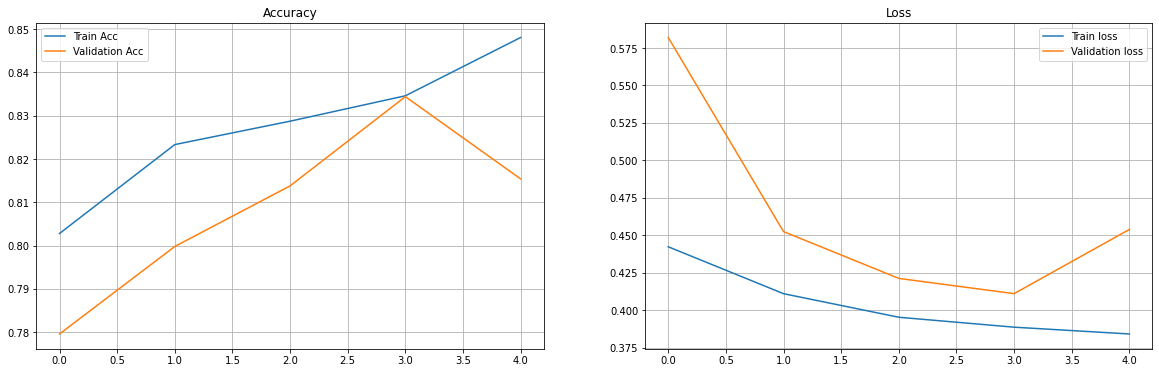

In [54]:
model_obj = DefineModel(model)
model_obj.train(5,50)
model_obj.evaluation()

In [62]:
class Prediction():
    def __init__(self):
        self.model = torch.load('/content/drive/My Drive/Projects/NLP-Notebooks/1.2-sentiment-analysis/state_dict.pt')
        self.max_len = 500
    def predict(self,text):
        prps_obj = PreprocessData()
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(prps_obj.padding(word_seq,self.max_len))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [63]:
pred_obj = Prediction()

In [64]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = pred_obj.predict(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [65]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = pred_obj.predict(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
torch.Size([1, 500])
predicted sentiment is negative with a probability of 0.9882652070373297
